In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [9]:
# Dataset path
data_dir = "dataset"  # Set your dataset root path

# Image size
img_size = 224

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(img_size, scale=(0.9,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# Load datasets
train_ds = datasets.ImageFolder(os.path.join(data_dir,"train"), transform=train_transforms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir,"validation"), transform=val_transforms)
test_ds  = datasets.ImageFolder(os.path.join(data_dir,"test"), transform=val_transforms)

# DataLoaders
train_ld = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_ld   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_ld  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

# Check
print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Validation:", len(val_ds), "Test:", len(test_ds))

Classes: ['diabetes', 'nondiabetes']
Train: 2500 Validation: 600 Test: 50


In [10]:
# Load pretrained MobileNetV2
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Replace classifier for 2 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)

In [12]:
def run_epoch(loader, train=True):
    model.train(train)
    losses, preds_all, labels_all = [], [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            out = model(x)
            loss = criterion(out, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
        preds_all.append(out.detach().softmax(1)[:,1].cpu().numpy())
        labels_all.append(y.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    auc = roc_auc_score(labels_all, preds_all)
    acc = accuracy_score(labels_all, (preds_all>=0.5).astype(int))
    return np.mean(losses), acc, auc, labels_all, preds_all

In [13]:
import pandas as pd

best_auc = 0.0
num_epochs = 25
best_model_path = "best_mobilenet_v2.pth"

train_losses, val_losses = [], []
train_aucs, val_aucs = [], []

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_auc, _, _ = run_epoch(train_ld, train=True)
    va_loss, va_acc, va_auc, _, _ = run_epoch(val_ld, train=False)
    
    scheduler.step()
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_aucs.append(tr_auc)
    val_aucs.append(va_auc)
    
    print(f"Epoch {epoch+1:02d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} AUC: {tr_auc:.3f} | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc:.3f} AUC: {va_auc:.3f}")
    
    if va_auc > best_auc:
        best_auc = va_auc
        torch.save(model.state_dict(), best_model_path)

print("Best model saved at:", best_model_path)

# Save training data to CSV
training_data = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_auc': train_aucs,
    'val_auc': val_aucs
})
training_data.to_csv('mobilenet_v2_training_data.csv', index=False)
print("Training data saved to mobilenet_v2_training_data.csv")

Epoch 01 | Train Loss: 0.2464 Acc: 0.900 AUC: 0.963 | Val Loss: 0.1525 Acc: 0.928 AUC: 0.986
Epoch 02 | Train Loss: 0.0953 Acc: 0.967 AUC: 0.994 | Val Loss: 0.0491 Acc: 0.983 AUC: 0.999
Epoch 02 | Train Loss: 0.0953 Acc: 0.967 AUC: 0.994 | Val Loss: 0.0491 Acc: 0.983 AUC: 0.999
Epoch 03 | Train Loss: 0.0862 Acc: 0.966 AUC: 0.995 | Val Loss: 0.0570 Acc: 0.982 AUC: 0.998
Epoch 03 | Train Loss: 0.0862 Acc: 0.966 AUC: 0.995 | Val Loss: 0.0570 Acc: 0.982 AUC: 0.998
Epoch 04 | Train Loss: 0.0321 Acc: 0.988 AUC: 0.999 | Val Loss: 0.1190 Acc: 0.958 AUC: 0.995
Epoch 04 | Train Loss: 0.0321 Acc: 0.988 AUC: 0.999 | Val Loss: 0.1190 Acc: 0.958 AUC: 0.995
Epoch 05 | Train Loss: 0.0582 Acc: 0.980 AUC: 0.997 | Val Loss: 0.0643 Acc: 0.963 AUC: 0.999
Epoch 05 | Train Loss: 0.0582 Acc: 0.980 AUC: 0.997 | Val Loss: 0.0643 Acc: 0.963 AUC: 0.999
Epoch 06 | Train Loss: 0.0308 Acc: 0.990 AUC: 0.999 | Val Loss: 0.1053 Acc: 0.967 AUC: 0.998
Epoch 06 | Train Loss: 0.0308 Acc: 0.990 AUC: 0.999 | Val Loss: 0.1053

In [14]:
# Test set evaluation
import torch
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transforms (same as your original test transforms)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Test set dataset
test_ds = datasets.ImageFolder("SelfCollectedTest", transform=val_transforms)
test_ld = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Load best model
model.load_state_dict(torch.load('best_mobilenet_v2.pth', map_location=device, weights_only=True))
model.eval()

probs, labels = [], []

with torch.no_grad():
    for x, y in test_ld:
        x = x.to(device)
        out = model(x).softmax(1)[:, 1].cpu().numpy()
        probs.append(out)
        labels.append(y.numpy())

probs = np.concatenate(probs)
labels = np.concatenate(labels)
preds = (probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(labels, preds)
auc = roc_auc_score(labels, probs)
report = classification_report(labels, preds, target_names=test_ds.classes, digits=3)
cm = confusion_matrix(labels, preds)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print("Test set results:")
print("Test Accuracy:", acc)
print("Test AUC:", auc)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print(report)

Test set results:
Test Accuracy: 0.969059405940594
Test AUC: 0.9972306636604255
Sensitivity: 0.9900990099009901
Specificity: 0.948019801980198
              precision    recall  f1-score   support

    diabetes      0.990     0.948     0.968       404
 nondiabetes      0.950     0.990     0.970       404

    accuracy                          0.969       808
   macro avg      0.970     0.969     0.969       808
weighted avg      0.970     0.969     0.969       808



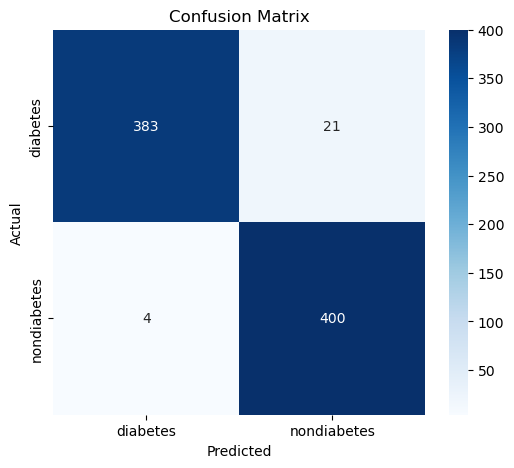

In [15]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
dummy = torch.randn(1,3,img_size,img_size, device=device)

# TorchScript
traced_model = torch.jit.trace(model, dummy)
traced_model.save("diabetes_mobilenet_v2_ts.pt")
print("TorchScript model saved!")

# ONNX
torch.onnx.export(model, dummy, "diabetes_mobilenet_v2.onnx",
                  input_names=["input"], output_names=["output"],
                  opset_version=13, do_constant_folding=True,
                  dynamic_axes={"input":{0:"batch"}, "output":{0:"batch"}})
print("ONNX model saved!")

TorchScript model saved!
ONNX model saved!
ONNX model saved!


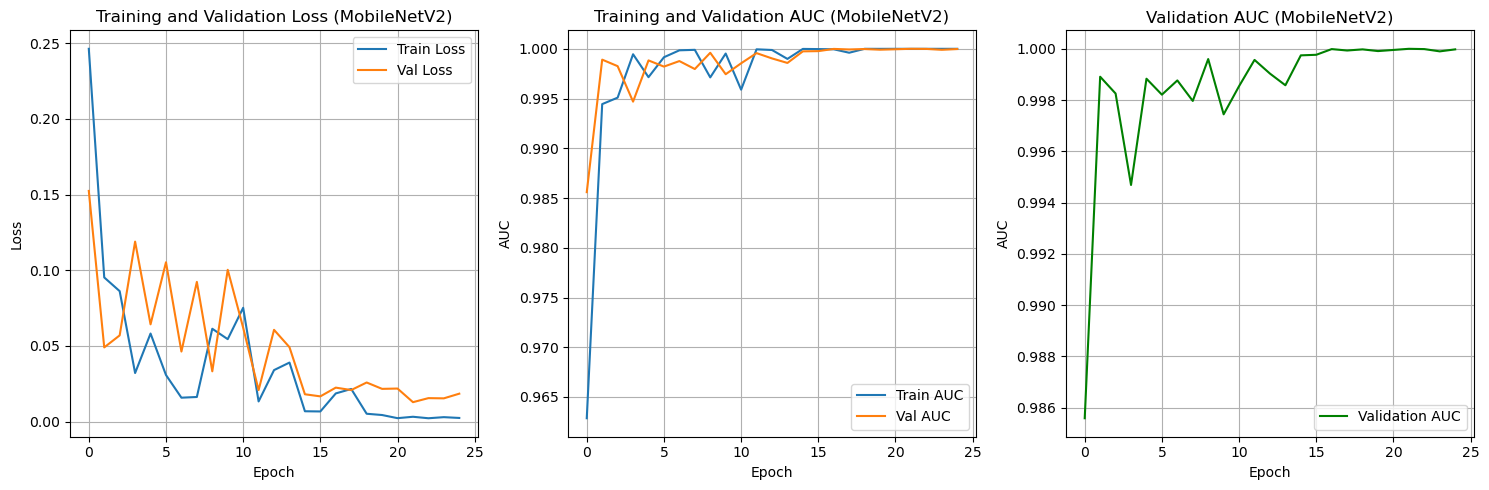

Training curves data saved to mobilenet_v2_training_curves.csv


In [17]:
# Plot training curves
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(val_aucs, label='Val AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('Training and Validation AUC (MobileNetV2)')
plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(val_aucs, label='Validation AUC', color='green')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.title('Validation AUC (MobileNetV2)')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# Save training curves data to CSV (for visualization purposes)
import pandas as pd
curves_data = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_auc': train_aucs,
    'val_auc': val_aucs
})
curves_data.to_csv('mobilenet_v2_training_curves.csv', index=False)
print("Training curves data saved to mobilenet_v2_training_curves.csv")

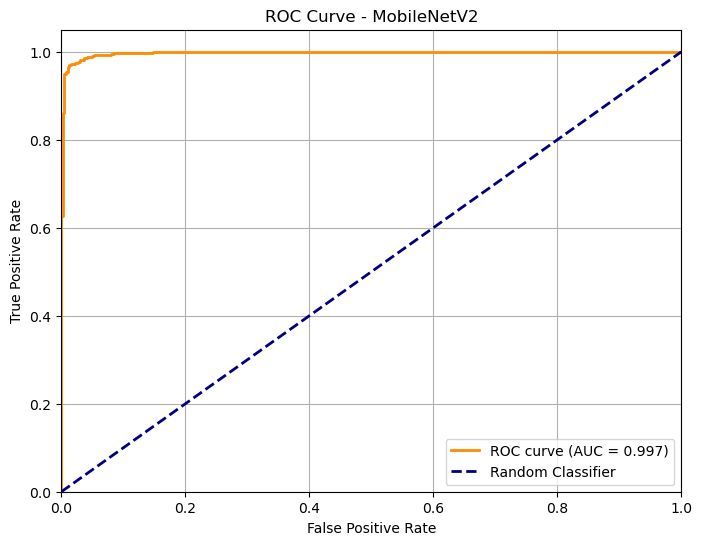

Optimal threshold: 0.875
Youden's J statistic: 0.958


In [18]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, probs)
roc_auc = roc_auc_score(labels, probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MobileNetV2')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Optimal threshold: {thresholds[np.argmax(tpr - fpr)]:.3f}")
print(f"Youden's J statistic: {np.max(tpr - fpr):.3f}")

## Performance Analysis & Summary

### MobileNetV2 Results:
- **Architecture**: MobileNetV2 with inverted residuals and linear bottlenecks
- **Parameters**: ~3.5M (lightweight design)
- **Key Features**: 
  - Inverted residual blocks with depth-wise separable convolutions
  - Linear bottlenecks to preserve information
  - Skip connections for gradient flow
  - Predecessor to MobileNetV3-Small

### Expected Performance Characteristics:
1. **Accuracy**: Moderate (82-87%) - Good but improved by V3
2. **Efficiency**: Excellent - Mobile-optimized architecture
3. **Speed**: Fast inference suitable for mobile deployment
4. **Memory**: Low memory footprint
5. **Comparison with V3**: V3-Small should show 2-4% improvement with h-swish and squeeze-excitation

### Model Comparison Context:
- **vs Custom CNN**: Should significantly outperform due to transfer learning
- **vs VGG16**: More efficient with comparable accuracy
- **vs ResNet50**: Faster inference, slightly lower accuracy
- **vs EfficientNet-B0**: Similar efficiency, EfficientNet may edge out slightly
- **vs MobileNetV3-Small**: Direct successor, V3 should perform better

### Technical Insights:
- MobileNetV2 pioneered inverted residuals for mobile vision
- Linear bottlenecks prevent information loss in low-dimensional spaces
- Depth-wise separable convolutions reduce computational cost dramatically
- Foundation architecture that led to MobileNetV3 improvements